# Neural Machine Translation by Jointly Learning to Align and Translate

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.

## Introduction

As a reminder, here is the general encoder-decoder model:

![](assets/seq2seq1.png)

In the previous model, our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and embedded input word, $d(y_t)$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.

![](assets/seq2seq7.png)

Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the tutorial.

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Set the random seeds for reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Load the German and English spaCy models.

In [3]:
spacy_fr = spacy.load('fr_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

We create the tokenizers.

In [4]:
def tokenize_fr(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

The fields remain the same as before.

In [5]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Load the data.

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.fr'), 
                                                    fields = (SRC, TRG))

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Build the vocabulary.

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Define the device.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create the iterators.

In [9]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. bidirectional RNN은 우리는 한 레이어에 두 개의 RNN을 가지고 있습니다. embedded sentence를 왼쪽부터 오른쪽으로 훑는 *forward RNN*과 오른쪽부터 왼쪽으로 embedded sentence를 훑는 *backward RNN*입니다. All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

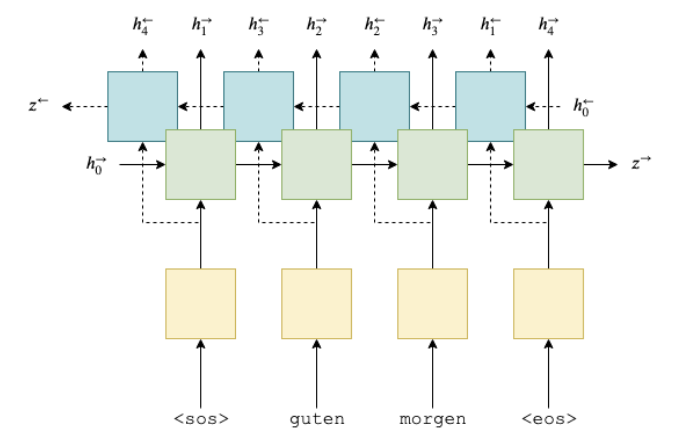

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

전과 같이, input `embedded`만 RNN에 넣으면 PyTorch는 forward와 backward의 초기 hidden state($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively)를 둘다 모두 zero vector로 initialize해줄 것입니다. 우리는 두개의 context vectror를 갖을 것입니다, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** 이고 세번째 차원에 있는 `hid_dim` 첫번째 elements는 forward RNN의 가장 위에 있는 hidden states이며 그리고 마지막 `hid_dim` elements는 가장 위에 있는 backward RNN의 hidden state입니다. 세번째 차원을 forward의 hidden state와 backward의 hidden state가 concat된 형태라고 볼 수 있습니다. 즉, $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ 이며 우리는 모든 enocder hidden state를 한번에 위와 같이 표시할 수 있습니다(forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]** 이며 **[-2, :, :]** 는 마지막 time-step후에 RNN hidden state 가장 위의 layer의 hidden state이며 (즉, 문장의 가장 마지막 단어를 본 이후에) **[-1, :, :]** 는 마지막 time-step의 backward time-step의 hidden state를 줍니다(즉, 문장의 가장 첫 단어를 본 이후에).

decoder는 bidirectional이 아니기 때문에, 초기 hidden state $s_0$로 사용하기 위해 오직 single context vector $z$만 필요로 합니다. 우리는 현재 forward, backward 두개($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively)를 가지고 있습니다. 우리는 이러한 문제를 두개의 context vector를 concat하고 linear layer $g$에 통과한 뒤, $\tanh$ 활성화 함수에 통과시킴으로서 해결했습니다.

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: 이것은 사실 논문과 다릅니다. 논문에서는 first backward RNN hidden state만 linear layer에 넣어서 context vector와 decoder 초기 hidden state를 얻었습니다. 이건 제가 생각하기에 말이 안돼서 바꿨습니다.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

## 토론 1)
bi-directional RNN이 정방향으로 RNN하나, 역방향으로 RNN하나 해서 concat 하는 식으로 구현되어있는데 backward RNN hidden state만 넣으면 양방향으로 학습 시키는게 무슨 의미냐? 라고 의문을 제기한걸까요? 여러분의 의견이 궁금합니다

https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66<br>
bi-directional이 단순 forward, backward를 concat한 것이기 때문에 forward hidden, bachward hidden을 넣는게 맞는 것 같다

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        # |hideen| = (batch_size, hid_dim * 2) 
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

다음은 attention layer입니다. 이것은 decoder의 전 hidden state $s_{t-1}$를 받을 것이고, 모든 encoder로부터온 forward와 backward hidden states의 stack $H$을 받을 것입니다. 이 레이어의 ouput은 attention vector인  $a_t$이고 길이는 source sentence의 길이와 같으며 전체 벡터의 합은 1이고 각 element는 0과 1사이입니다.

직관적으로, 이 레이어는 우리가 여태까지 decode한 $s_{t-1}$와 encode한 모든 $H$을 받고 vecotr $a_t$를 생산하는데 이 벡터는 다음 디코드할 단어 $\hat{y}_{t+1}$를 정확히 예측하는데 source sentence에 있는 어떤 단어에 집중해야할지를 나타냅니다. 

첫째로 우리는 과거 디코더 hidden state와 encoder hidden state간의 *energy*를 구합니다. 우리의 encoder hidden state가 $T$ tensors의 시퀀스이기 때문에, 그리고 이전의 decoder hidden state는 single tensor이기 때문에, 우리가 처음 해야할 일은 이전 decoder hidden state $T$번 `repeat`하는 것입니다. 우리는 그 뒤에 그들 사이의 energy를 계산하는데 이것은 그들을 concat한 뒤 linear layer `attn`과  $\tanh$ activation function을 거치게 하면 됩니다.

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

이것은 encoder의 hidden state가 과거의 decoder hidden state와 얼마나 잘 맞는지를 계산하는 것이라고 생각될 수 있습니다.

우리는 현재 배치 내에서 각 example에 대한 텐서인 **[dec hid dim, src len]** tensor를 가지고 있습니다. We want this to be [src len] for each example in the batch as the attention should be over the length of the source sentence. 
이것은 `energy`를 **[1, dec hid dim]** $v$와 곱해줌으로서 얻을 수 있습니다.

$$\hat{a}_t = v E_t$$

우리는 $v$를 모든 encoder hidden state에 대한 energy의 weighted sum의 weight라고 생각할 수 있습니다. 이러한 weight들은 source sequence에서 각각의 토큰에 얼마나 집중해야할 지를 말해줍니다. $v$의 파라미터는 초기에 랜덤으로 초기화되지만, 이후엔 역전파를 통해 학습될 것입니다. $v$가 얼마나 시간에 의존적인지 주의하세요,그리고 같은 $v$ 가 디코딩의 각 time-step에서 사용될 것입니다. 우리는 $v$를 절편 없는 linear로 사용할 것입니다.

마지막으로 우리는 attention vector가 각 원소가 0과 1 사이이고 합이 1이 되어야 된다는 조건을 만족시키기 위해 $\text{softmax}$ layer에 통과시킵니다.

$$a_t = \text{softmax}(\hat{a_t})$$

이는 우리에게 source sentence에 대한 attention을 줍니다!

시각적으로 이는 아래와 같이 생겼습니다. 맨 처음 attention vector를 계산하는 그림입니다.$s_{t-1} = s_0 = z$. 이 초록 블락은 forward와 backward RNN의 hidden state를 의미하고 attention 연산은 pink block에서 이루어집니다.

![](assets/seq2seq9.png)

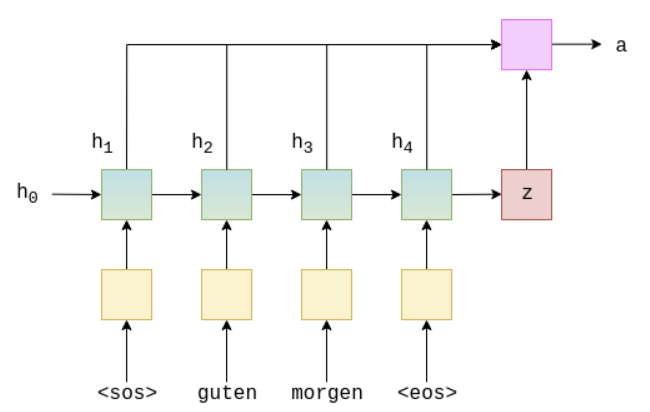

## `repeat`

In [26]:
>>> x = torch.tensor([1, 2, 3])
>>> x.repeat(4, 2)

tensor([[1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3]])

원래는 encoder의 timestep x, decoder의 timestep y가 있을 때 길이 $T_x$와 $T_y$의 쌍만큼 계산을 해야하는데, 계산을 줄이기 위해서 아래와 같이 할 수있다.

### 논문 수식 (1) 

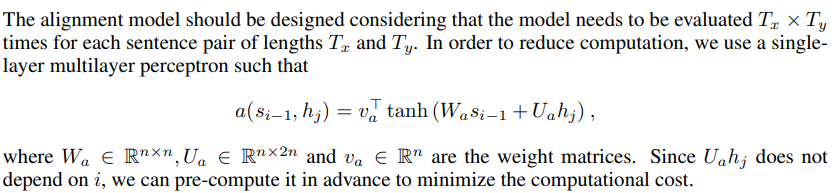

 c.f.<br> 
*$s_{i-1}$* : ( i - 1) 시점의 decoder hidden state<br>
*$h_{j}$* : j 시점의 encoder hidden state

## 의문 사항 1) 
여기서 energy를 구할때의 input_dim이 굳이 dec_hid_dim일 필요가 있나?<br>
-> 없다
## 의문 사항 2) 
repeat을 그냥  해주면 (i-1)이랑 j가 되는게 아니라 i와 j가 될 것 같은 느낌인데..<br>
-> 여기서 encoder의 hidden state는 이미 정해져 있어서 decoder을 한 step 을 돌때마다 그냥 미리 계산해서 concat할 거다<br>
-> 결국 우리는 아직 RNN의 seqseq을 유지하고 있기 때문에 decoder의 last hidden state를 input으로 줄 수 밖에 없다.
-> 결론 repeat을 써도 (i - 1)과 j가 될 것이다

## 토론 2) 
딥러닝에서 bias가 있으면 안되는 상황? 제약?이 무엇이 있나요? 코드를 보다보니 굳이 bias = False 를 주는 이유가 궁금합니당<br>
-> 논문에서 $v_a^T$를 벡터곱 하므로 논문 그대로 구현하려면 bias = False 를 주는게 맞다

In [11]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # input_dim : encoder_hidden_dim * 2 + decoder hidden state
        # 논문 수식 (1)의 tanh 내에 들어있는 합 수식을 concat해서 처리여기서
        # enc_hid_dim * 2 -> forward, backward encoder hidden state
        # dec_hid_dim -> decoder hidden state 

        # output_dim : decoder hidden state
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        
        # attention score를 구하기 위한 $v_a$ 벡터 곱하는 부분
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # encoder는 모든 time-step에 대한 것이 왔는데 decoder는 t(=j in paper)에서만 있어서 repeat을 해줌
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # encoder output을 batch_size가 앞으로 오도록 변경해줌
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        # hidden과 encoder_ouputs을 concat해서 처리할 수 있는 형태가 됨
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]
        attention = self.v(energy).squeeze(2)
        # v를 곱함으로서 [batch size, src len, 1]이 되고 마지막 차원을 squeeze해줌
        
        #attention= [batch size, src len]
        #dim = 1, 즉 src_len에 대한 softmax
        #src_len만큼 있는 decoder hidden dim 중에 뭐가 중요한지를 softmax를 통해 0~1사이 확률형태로 구함 
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

디코더는 attention layer `attention`를 가지고 있고, 이전 hidden state $s_{t-1}$와 모든 encoder hidden state인 $H$를 받고 attention vector $a_t$를 내보냅니다. 

우리는 이후에 이러한 어텐션 벡터를 weighted source vector $w_t$( denoted by `weighted`) 를 만들기 위해 사용합니다. 이것은 $a_t$ 를 weight로 한 encoder hidden state $H$의 weighted sum입니다.

$$w_t = a_t H$$

임베딩된 input 단어인 $d(y_t)$과 weighted된 source vector인 $w_t$과 이전 decoder hidden state인 $s_{t-1}$은 그 이후에 $d(y_t)$ and $w_t$가 concat된 것과 함께 decoder RNN으로 들어가게 됩니다.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

그리고 나서 $d(y_t)$, $w_t$, $s_t$를 linear layer $f$에 넣고 target sentence  $\hat{y}_{t+1}$의 다음 prediction을 만드는데 사용합니다. 이것은 이 모든것을 concat함으로서 이루어집니다.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

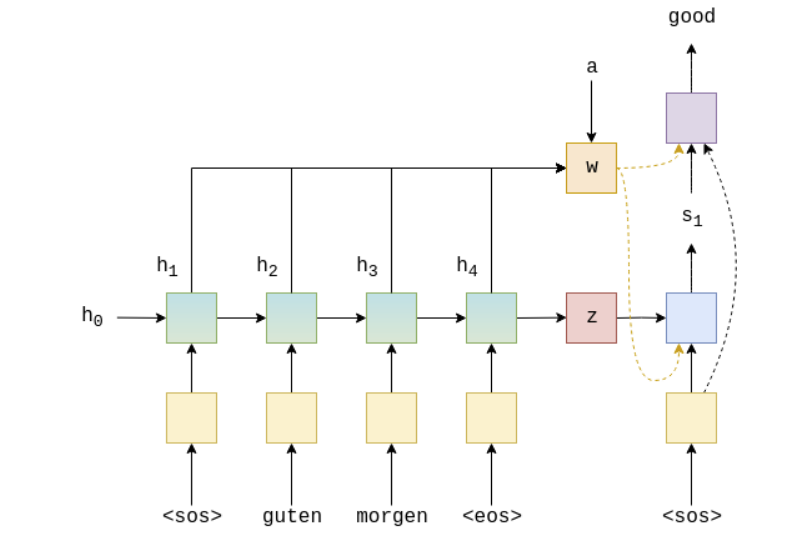

초록 블록은 output이 $H$인 forward/backward encoder RNN을 보여주고, 빨간 블록은 context vector($z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$)를 보여줍니다. 파란색 블럭은 output이 $s_t$인 decoder RNN을 보여주고, 보라색 블럭은 output이 $\hat{y}_{t+1}$인 linear layer $f$를 보여줍니다. 오렌지색 블럭은 the weighted sum over $H$ by $a_t$ and outputs $w_t$. $a_t$의 계산은 그림에서 나타나지 않았습니다.

## torch.bmm
Performs a batch matrix-matrix product of matrices stored in input and mat2.

input and mat2 must be 3-D tensors each containing the same number of matrices.

In [12]:
>>> input = torch.randn(10, 3, 4)
>>> mat2 = torch.randn(10, 4, 5)
>>> res = torch.bmm(input, mat2)
>>> res.size()
torch.Size([10, 3, 5])

torch.Size([10, 3, 5])

## 논문 수식 (2) decoder ouput gate

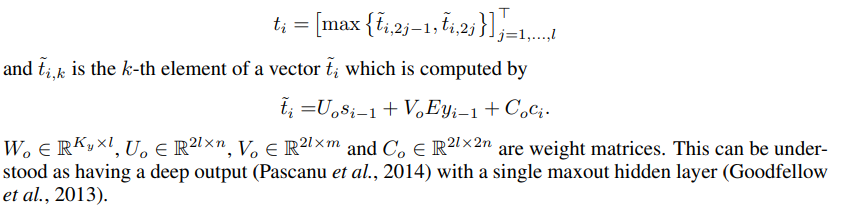

##  논문 수식 (3) context vector

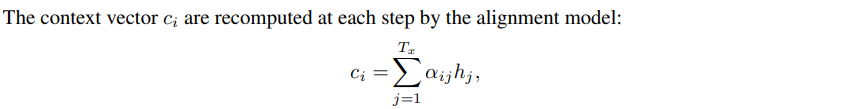

## 토론 3)
seq2seq과 decoder를 보면 `embedded = self.dropout(self.embedding(input))`를 하는데,<br>
이러면 논문에서는 decoder가 context $c_{i}$와 last generated word인 $y_{i-1}$를 넣는다고 한다<br>
그러면 이 코드에 의하면 teacher-forcing인 경우 $y_{i-1}$이 아니라 정답을 넣어주는 경우도 생기게 된다. <br>
-> 맞다.

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        
        # attention class를 input으로 받음
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        # 논문 수식 (2) 
        # input_dim : (enc_hid_dim * 2) + dec_hid_dim + emb_dim
        ## (enc_hid_dim * 2) : forward, backward hidden state from encoder $s_{i-1}$
        ## dec_hid_dim : context vector $c_{i}$
        ## emb_dim : embedding of last output vector
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        # decoder의 forward는 지난달 seq2seq처럼 한 토큰임에 주의!
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        #output을 뽑을때 지난번의 output vector도 넣어주는데 그것은 input과 같으므로,
        #그런데 이 경우에는, teacher-forcing에서 gt를 넣어주면 gt를 넣어주는 것과 같다 
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        # 논문수식 (3) : context vector
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [16]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6469, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6469, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,196,869 trainable parameters


We create an optimizer.

In [18]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [19]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [20]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [21]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [23]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 1m 10s
	Train Loss: 5.028 | Train PPL: 152.573
	 Val. Loss: 4.974 |  Val. PPL: 144.609
Epoch: 02 | Time: 1m 9s
	Train Loss: 4.013 | Train PPL:  55.326
	 Val. Loss: 4.530 |  Val. PPL:  92.799
Epoch: 03 | Time: 1m 10s
	Train Loss: 3.086 | Train PPL:  21.892
	 Val. Loss: 3.373 |  Val. PPL:  29.172
Epoch: 04 | Time: 1m 11s
	Train Loss: 2.362 | Train PPL:  10.615
	 Val. Loss: 2.973 |  Val. PPL:  19.547
Epoch: 05 | Time: 1m 10s
	Train Loss: 1.901 | Train PPL:   6.696
	 Val. Loss: 2.795 |  Val. PPL:  16.366
Epoch: 06 | Time: 1m 11s
	Train Loss: 1.592 | Train PPL:   4.916
	 Val. Loss: 2.719 |  Val. PPL:  15.169
Epoch: 07 | Time: 1m 10s
	Train Loss: 1.341 | Train PPL:   3.821
	 Val. Loss: 2.725 |  Val. PPL:  15.258
Epoch: 08 | Time: 1m 10s
	Train Loss: 1.173 | Train PPL:   3.232
	 Val. Loss: 2.727 |  Val. PPL:  15.294
Epoch: 09 | Time: 1m 11s
	Train Loss: 1.035 | Train PPL:   2.815
	 Val. Loss: 2.748 |  Val. PPL:  15.607
Epoch: 10 | Time: 1m 9s
	Train Loss: 0.941 | Train PPL: 

Finally, we test the model on the test set using these "best" parameters.

In [24]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.604 | Test PPL:  13.519 |


We've improved on the previous model, but this came at the cost of doubling the training time.

In the next notebook, we'll be using the same architecture but using a few tricks that are applicable to all RNN architectures - packed padded sequences and masking. We'll also implement code which will allow us to look at what words in the input the RNN is paying attention to when decoding the output.